#Predict the Geo, Segment, and Subgroup of Women

https://gallery.cortanaintelligence.com/Competition/Womens-Health-Risk-Assessment-1


In [40]:
import pandas as pd
import pprint
pp = pprint.PrettyPrinter(indent=4)

from azureml import Workspace
ws = Workspace(
    workspace_id='7908079269804b3489b56f0ca3e9f374',
    authorization_token='f51ff9ede2ab4330b63797cf73f73d5f',
    endpoint='https://studioapi.azureml.net'
)
ds = ws.datasets['WomenHealth_Training.csv']
data = ds.to_dataframe()

data['geo_segment']= (data['geo'].astype('str') + '_' + (data['segment'].astype('str')))
original_columns = data.columns.tolist()

regions = pd.get_dummies(data['REGION_PROVINCE'], prefix='region')
data = pd.concat([data, regions], axis=1, join='inner')
region_columns=regions.columns.tolist()

tribes = pd.get_dummies(data['tribe'], prefix='tribe')
data = pd.concat([data, tribes], axis=1, join='inner')
tribe_columns=tribes.columns.tolist()

In [3]:
booleans = ['christian',
            'muslim',
            'hindu',
            'other',
            'cellphone',
            'motorcycle',
            'radio',
            'cooker',
            'fridge',
            'furniture',
            'computer',
            'cart',
            'irrigation',
            'thrasher',
            'car',
            'generator',
            'EVER_HAD_SEX',
            'EVER_BEEN_PREGNANT',
            'CHILDREN',
            'india',
            'married',
            'inschool',
            'ownincome',
            'LaborDeliv',
            'ModCon',
            'usecondom',
            'hivknow',
            'lowlit',
            'highlit',
            'urban',
            'rural',
            'single']

cat = ['electricity',
      'foodinsecurity',
      'urbanicity',
      'tribe']

column_changes = [(booleans, 'bool'),
                 (cat, 'object')
                 ]

In [4]:
def change_column(columns, as_type):
    for column in columns:
        data[column] = data[column].astype(as_type)

In [5]:
for column, as_type in column_changes:
    change_column(column, as_type)

## What is the relationship between the three dependent variable?

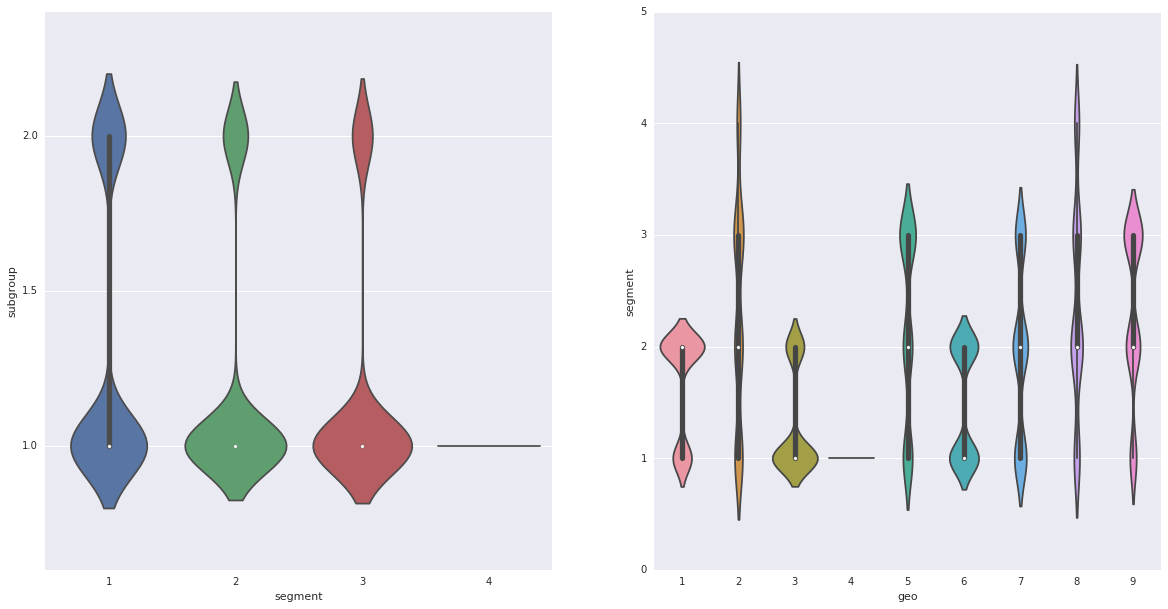

In [195]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

fig = plt.figure(num = 1, figsize=(20, 10))
fig.add_subplot(121)
sns.violinplot(data=data[['geo', 'segment', 'subgroup']],x='segment', y='subgroup')
fig.add_subplot(122)
sns.violinplot(data=data[['geo', 'segment', 'subgroup']],x='geo', y='segment')

##Does Religon Affect Geo or Subgroup?

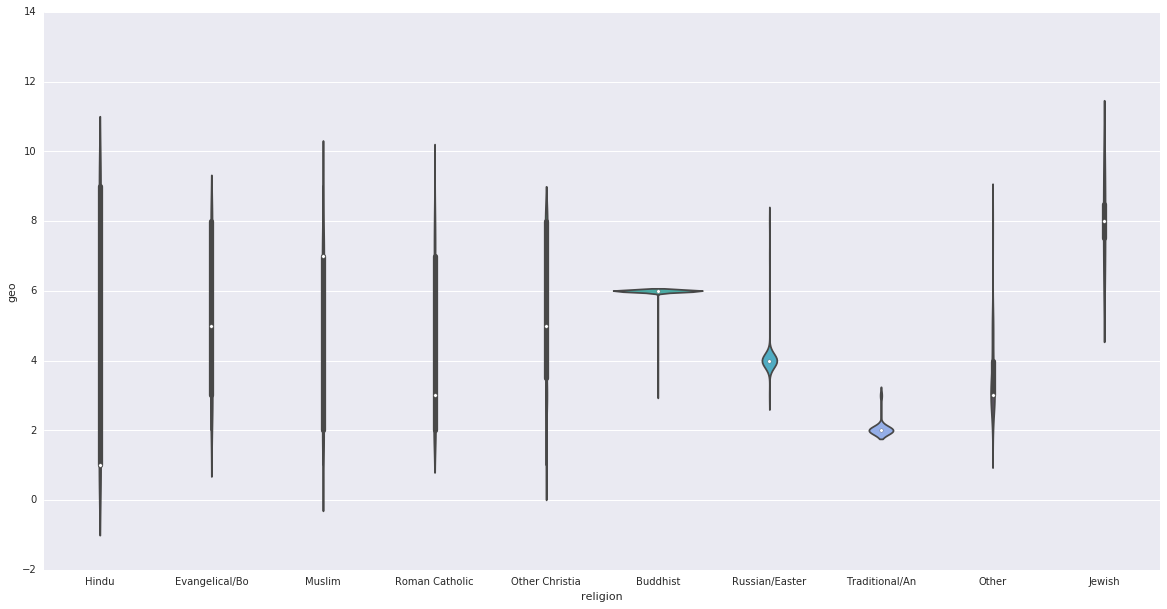

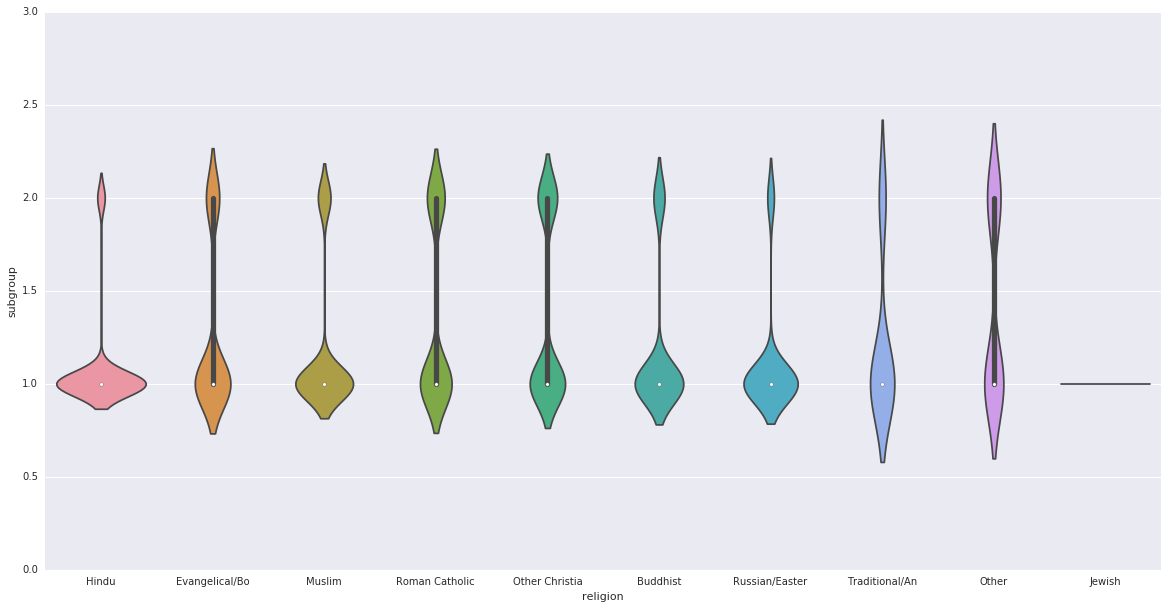

In [8]:
plt.figure(num = 1, figsize=(20, 10))
sns.violinplot(data=data[['geo', 'segment', 'subgroup','religion']],x='religion', y='geo')
plt.figure(num = 2, figsize=(20, 10))
sns.violinplot(data=data[['geo', 'segment', 'subgroup','religion']],x='religion', y='subgroup')

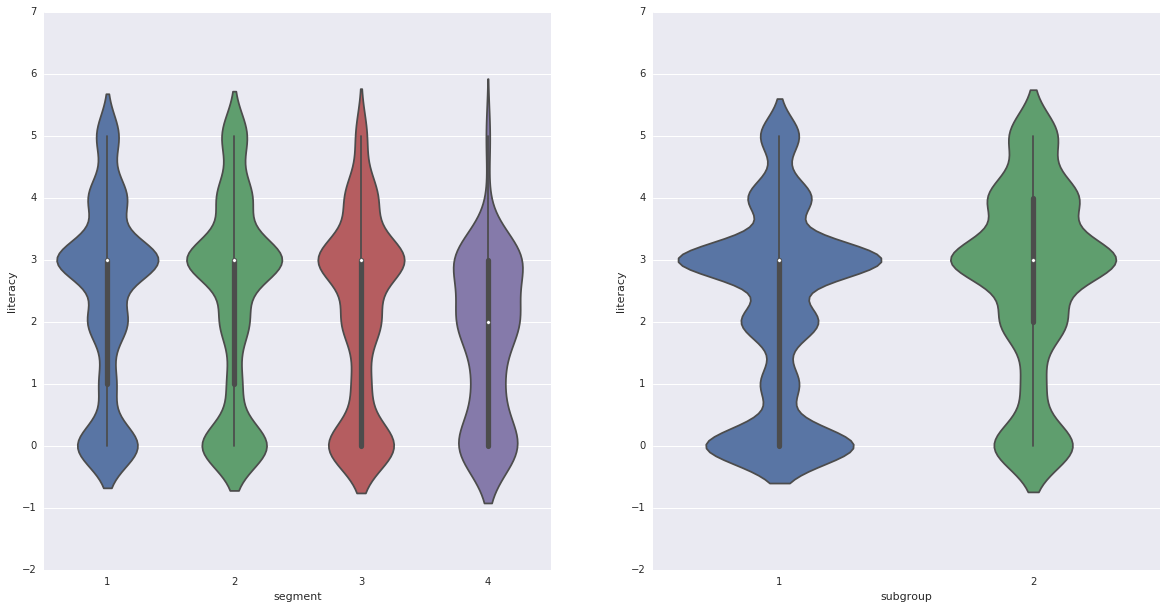

In [9]:
fig = plt.figure(num = 1, figsize=(20, 10))
fig.add_subplot(121)
sns.violinplot(data=data[['geo', 'segment', 'subgroup','literacy']],x='segment', y='literacy')
fig.add_subplot(122)
sns.violinplot(data=data[['geo', 'segment', 'subgroup','literacy']],x='subgroup', y='literacy')

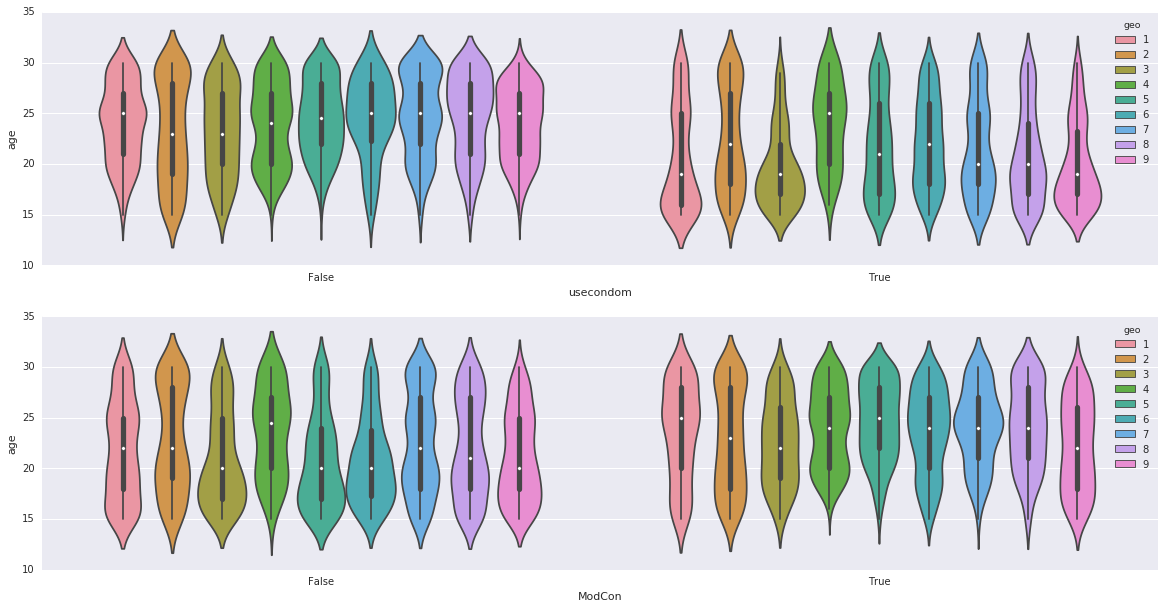

In [10]:
fig = plt.figure(num = 1, figsize=(20, 10))
fig.add_subplot(211)
sns.violinplot(data=data[['age', 'usecondom', 'ModCon', 'geo']],x='usecondom', y='age', hue='geo')
fig.add_subplot(212)
sns.violinplot(data=data[['age', 'usecondom', 'ModCon', 'geo']],x='ModCon', y='age', hue='geo')

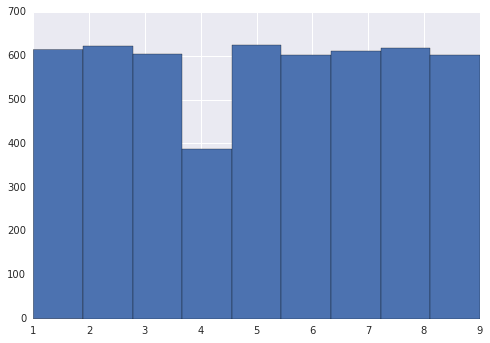

In [11]:
data.geo.hist(bins=9)

In [12]:
data[['literacy','religion', 'urban','geo','inschool','educ']].corr()

literacy     urban       geo  inschool      educ
literacy  1.000000  0.207478  0.170117  0.281971  0.584825
urban     0.207478  1.000000  0.100672  0.046522  0.230242
geo       0.170117  0.100672  1.000000  0.025833  0.400067
inschool  0.281971  0.046522  0.025833  1.000000  0.246865
educ      0.584825  0.230242  0.400067  0.246865  1.000000

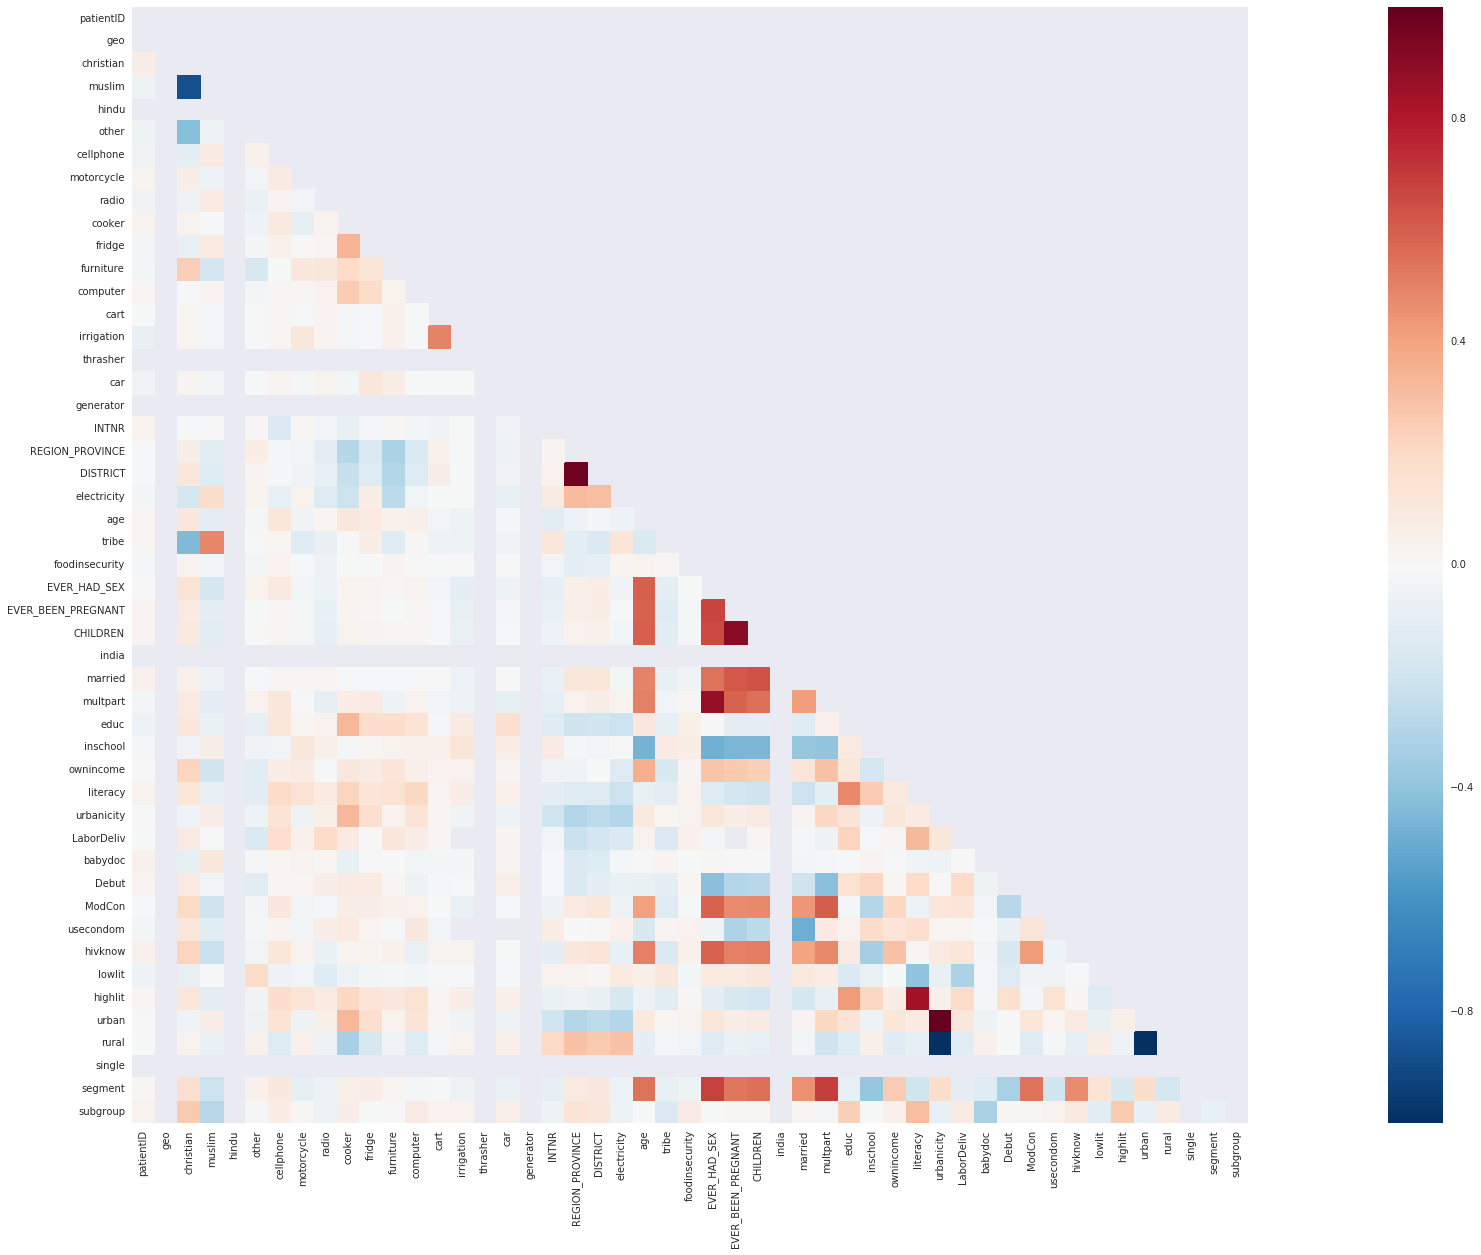

In [244]:
import numpy as np
fig = plt.figure(num = 1, figsize=(50, 20))
mask = np.zeros_like(data[original_columns].corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=data[data['geo']==5][original_columns].corr(), mask=mask, square=True)

##Predict Geo

In [14]:
from sklearn.naive_bayes import GaussianNB
geo_gnb = GaussianNB()

In [197]:
import pickle
geo_predictors_col = ['educ','christian','muslim','hindu','other','ownincome','CHILDREN']
geo_predictors_col = geo_predictors_col + region_columns
geo_predictors = data.dropna()[geo_predictors_col]
from sklearn.cross_validation import train_test_split
geo_train, geo_test, geo_y_train, geo_y_test = train_test_split(geo_predictors,
                                                                    data.dropna()['geo'],
                                                                    test_size=0.33,
                                                                    random_state=42)
geo_model = geo_gnb.fit(geo_train ,y=geo_y_train)

geo_predict = geo_model.predict(geo_test)

print(geo_y_test[geo_y_test != geo_predict].count())
print(geo_y_test.count())
print(geo_y_test[geo_y_test != geo_predict].count()/geo_y_test.count())

7
709
0.0098730606488


##EDA for Segment

Each segment within a geo is unique.

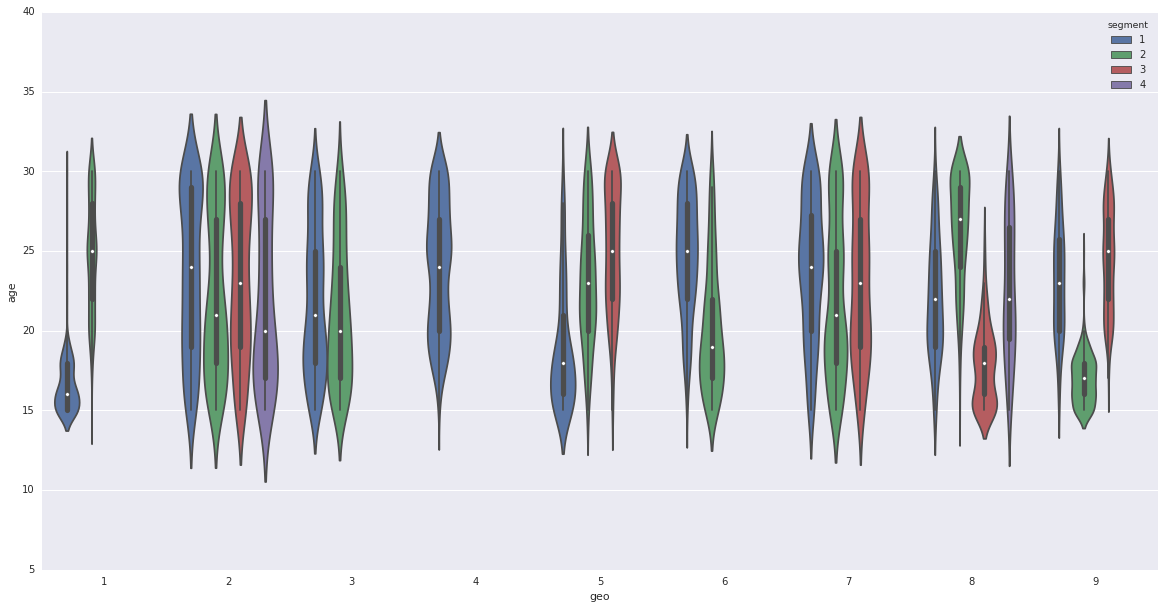

In [16]:
plt.figure(num = 1, figsize=(20, 10))
sns.violinplot(data=data[['geo', 'segment', 'age','religion']],x='geo', y='age', hue='segment')

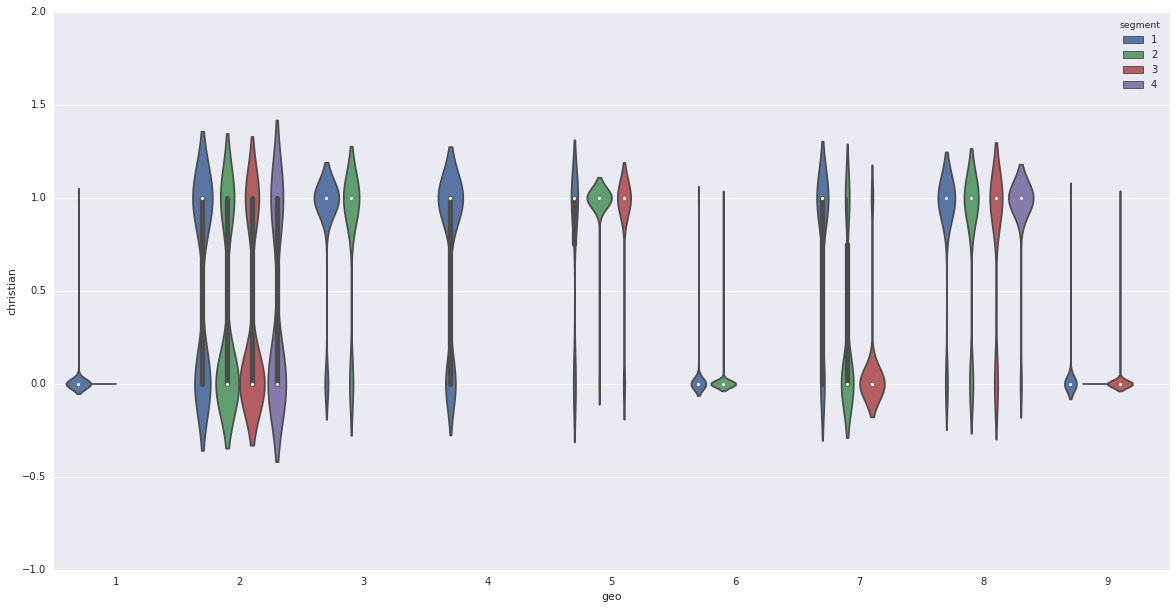

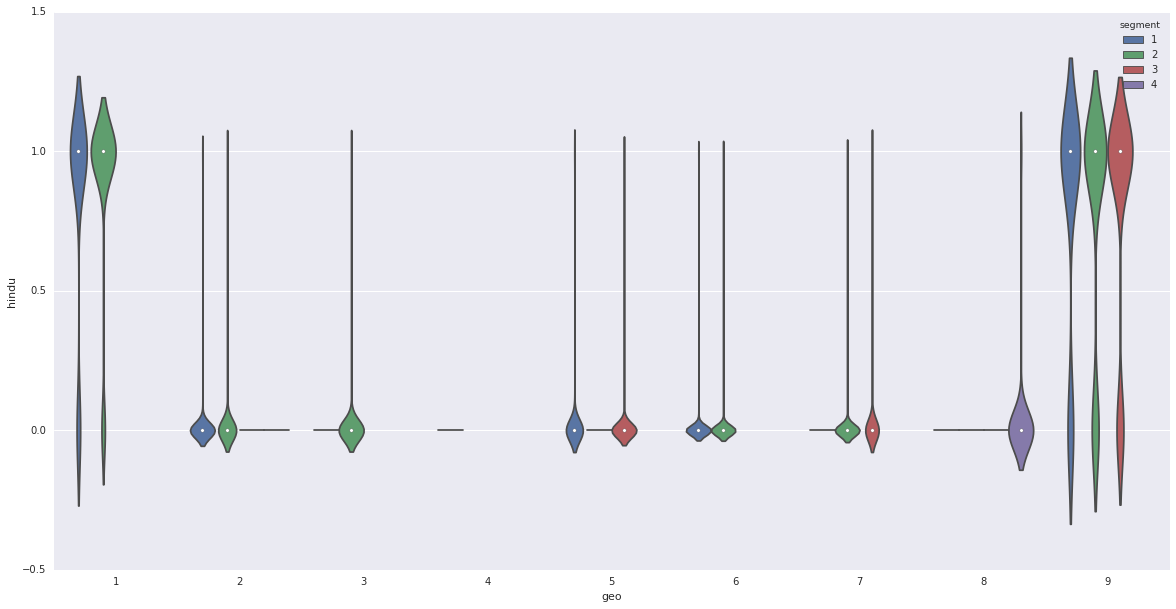

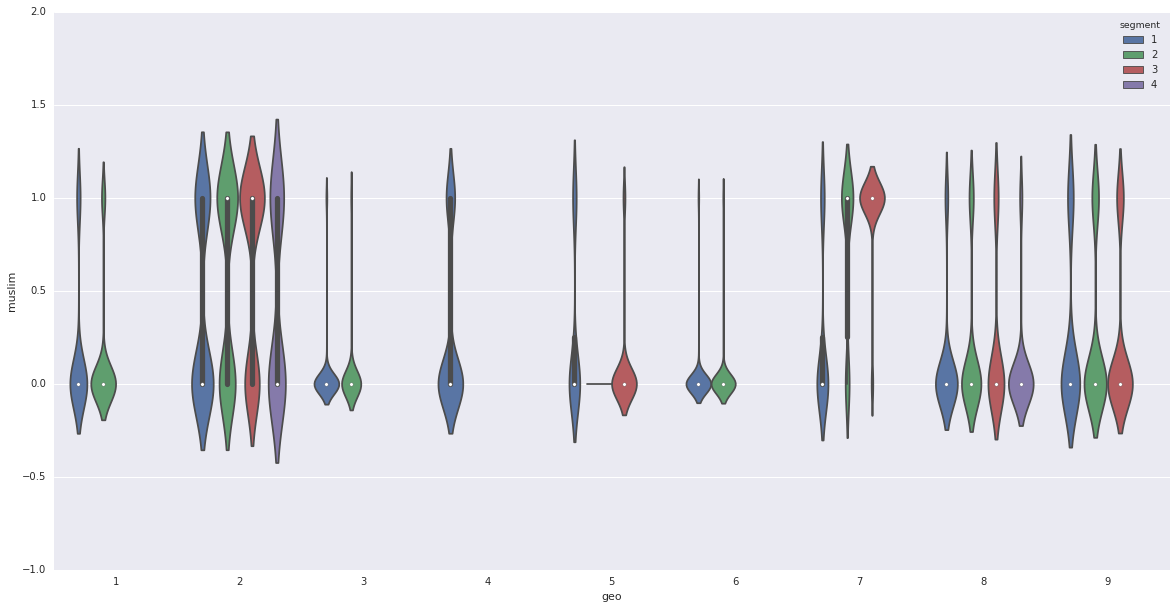

In [17]:
plt.figure(num = 1, figsize=(20, 10))
sns.violinplot(data=data[['geo', 'segment', 'age','urbanicity', 'christian']],x='geo', y='christian', hue='segment')
plt.figure(num = 2, figsize=(20, 10))
sns.violinplot(data=data[['geo', 'segment', 'age','urbanicity', 'hindu']],x='geo', y='hindu', hue='segment')
plt.figure(num = 3, figsize=(20, 10))
sns.violinplot(data=data[['geo', 'segment', 'age','urbanicity', 'muslim']],x='geo', y='muslim', hue='segment')

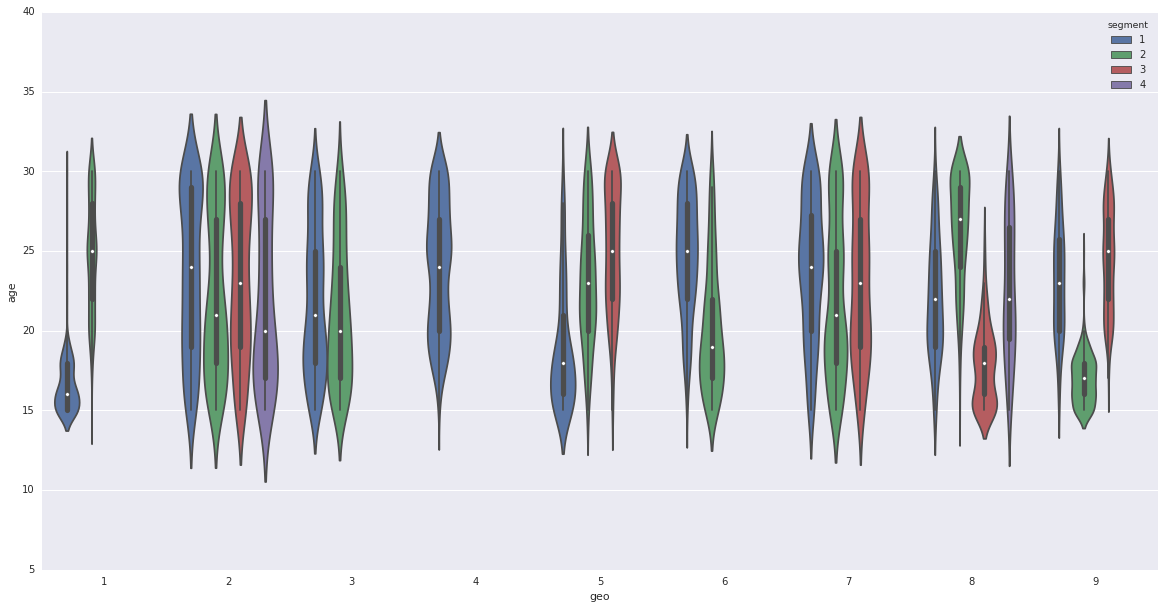

In [19]:
plt.figure(num = 1, figsize=(20, 10))
sns.violinplot(data=data[['geo', 'segment','age']], x='geo', y='age', hue='segment')

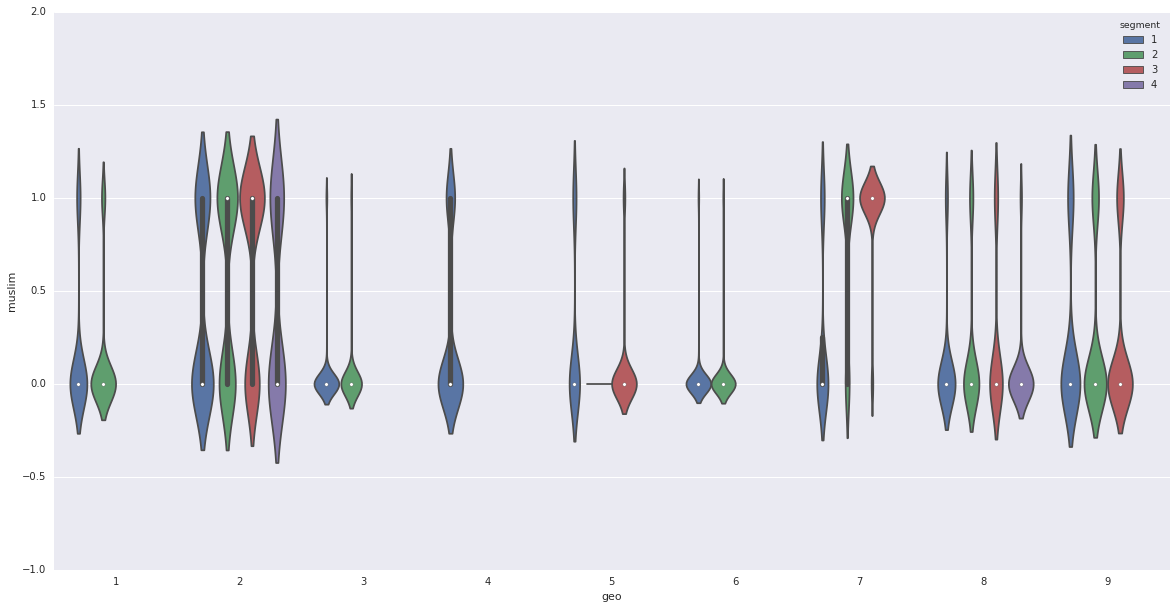

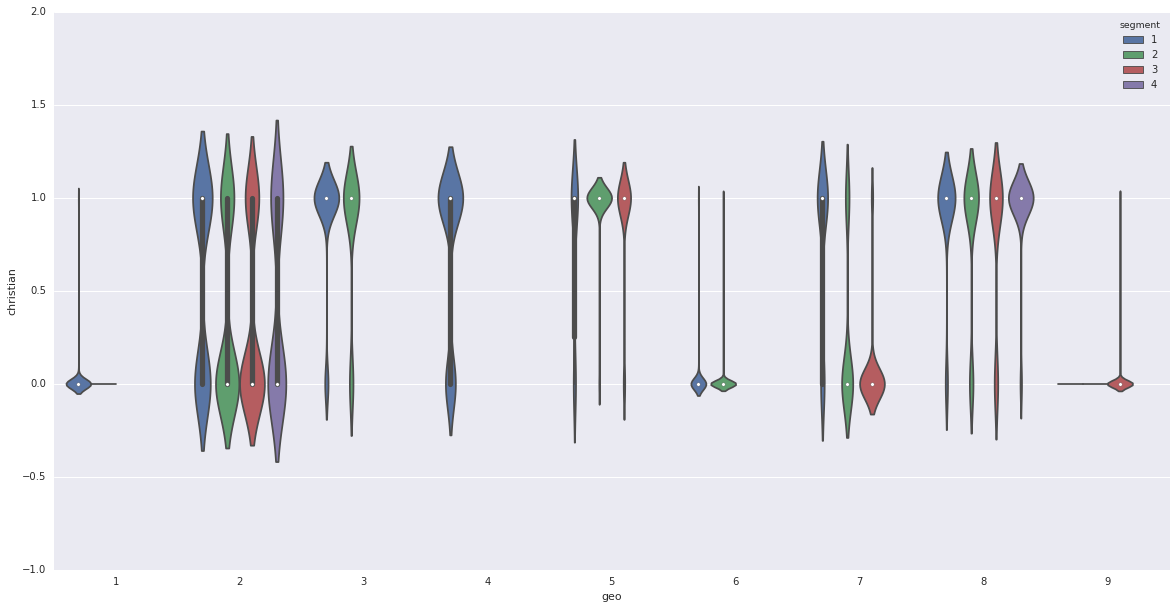

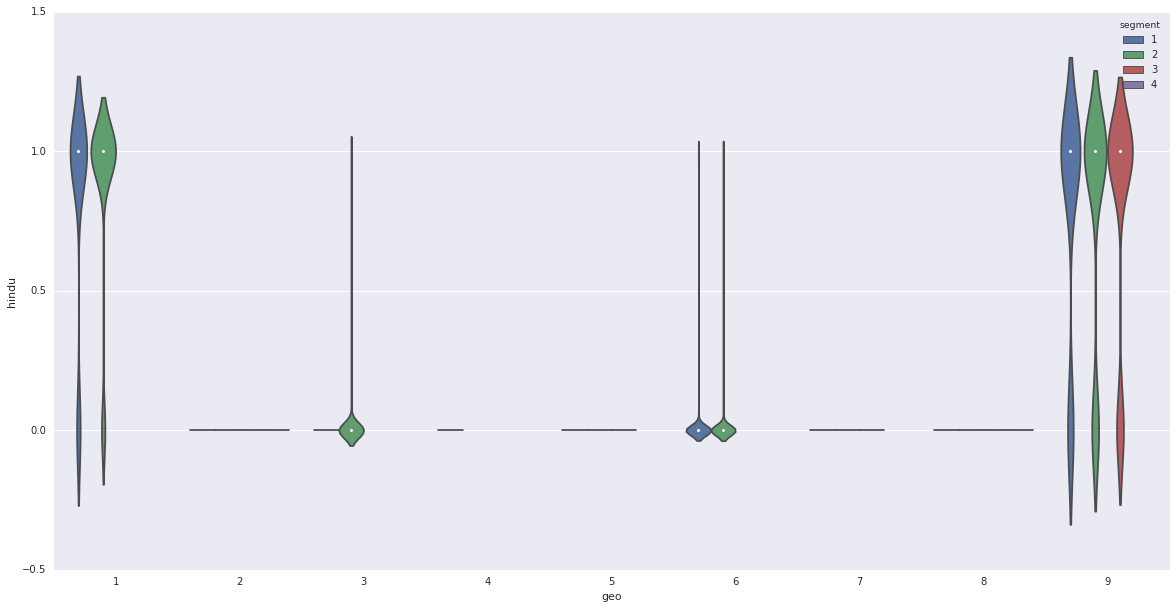

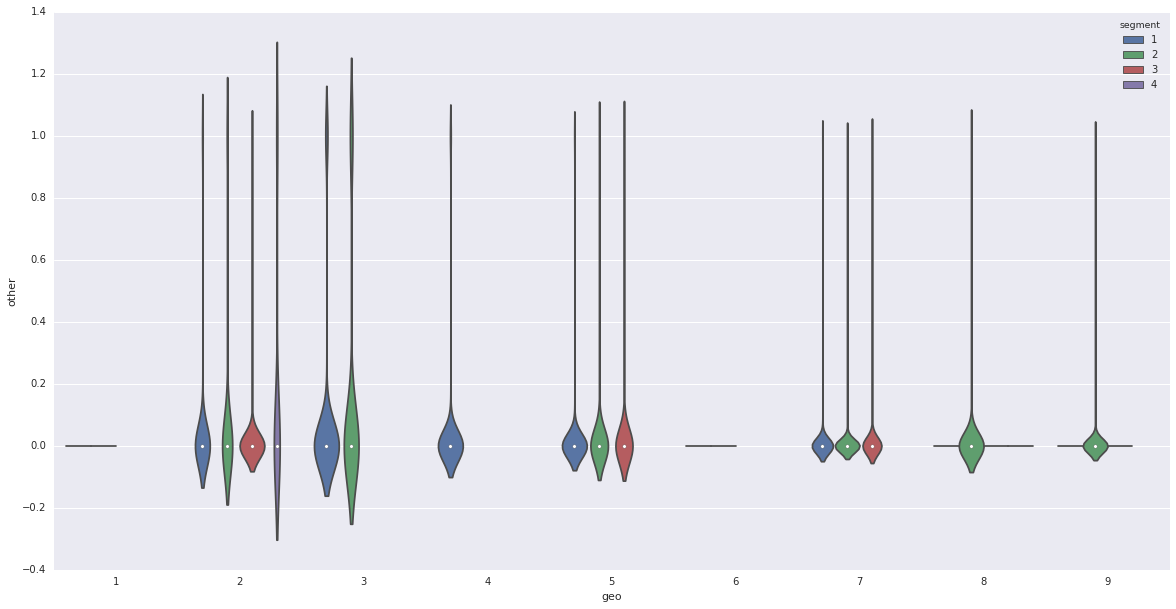

In [297]:
plt.figure(num = 1, figsize=(20, 10))
sns.violinplot(data=data,x='geo', y='muslim', hue='segment')
plt.figure(num = 2, figsize=(20, 10))
sns.violinplot(data=data,x='geo', y='christian', hue='segment')
plt.figure(num = 3, figsize=(20, 10))
sns.violinplot(data=data,x='geo', y='hindu', hue='segment')
plt.figure(num = 4, figsize=(20, 10))
sns.violinplot(data=data,x='geo', y='other', hue='segment')

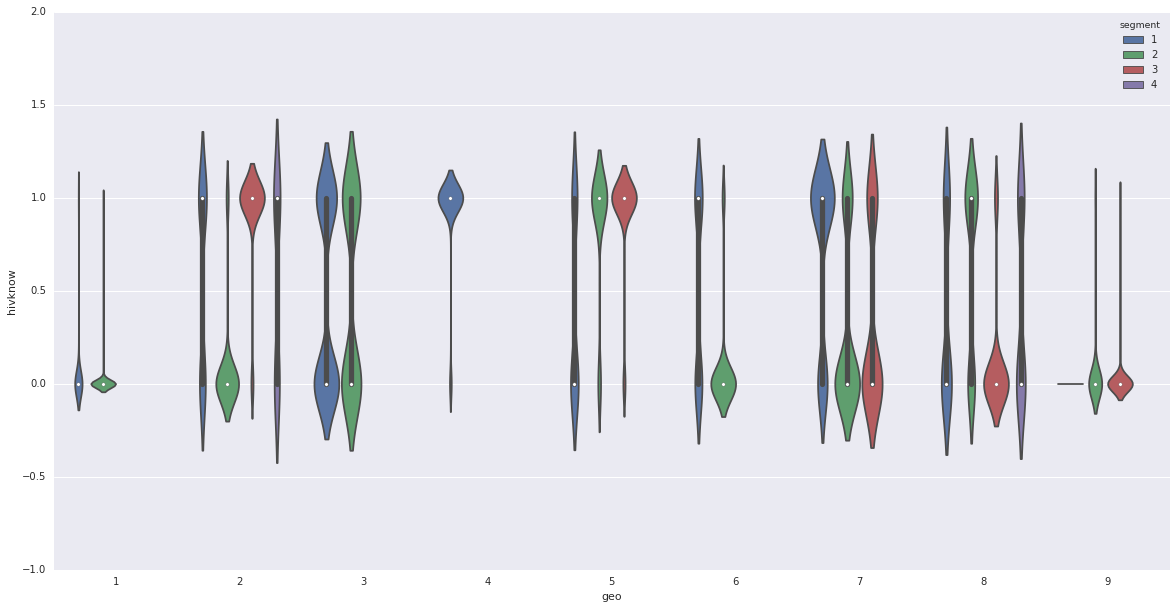

In [367]:
plt.figure(num = 1, figsize=(20, 10))
sns.violinplot(data=data,x='geo', y='hivknow', hue='segment')

##Explore Geo 5

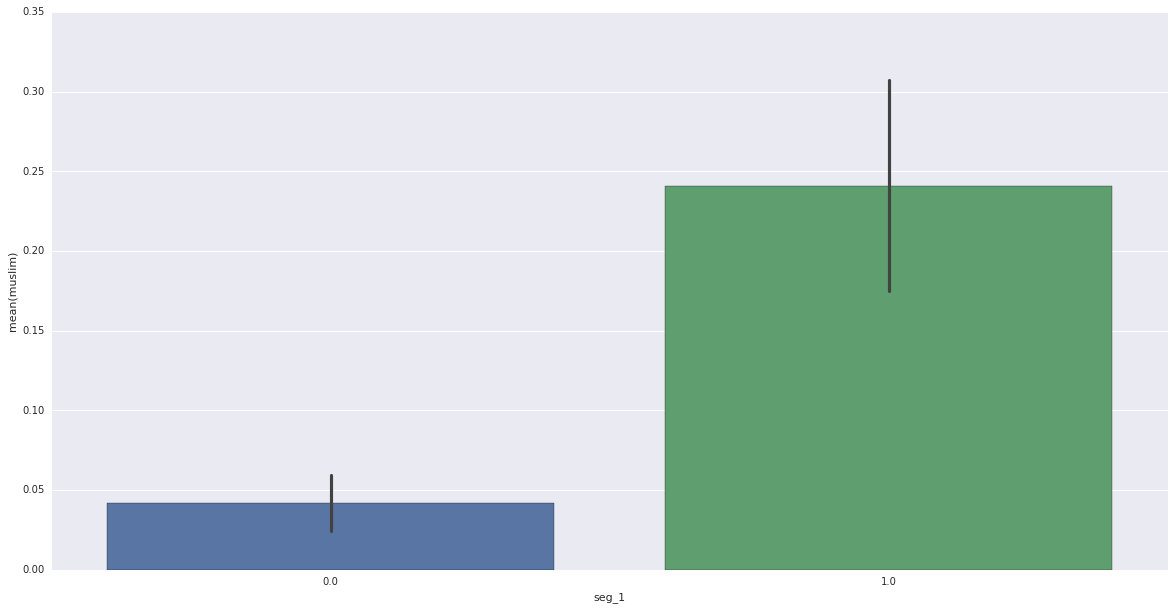

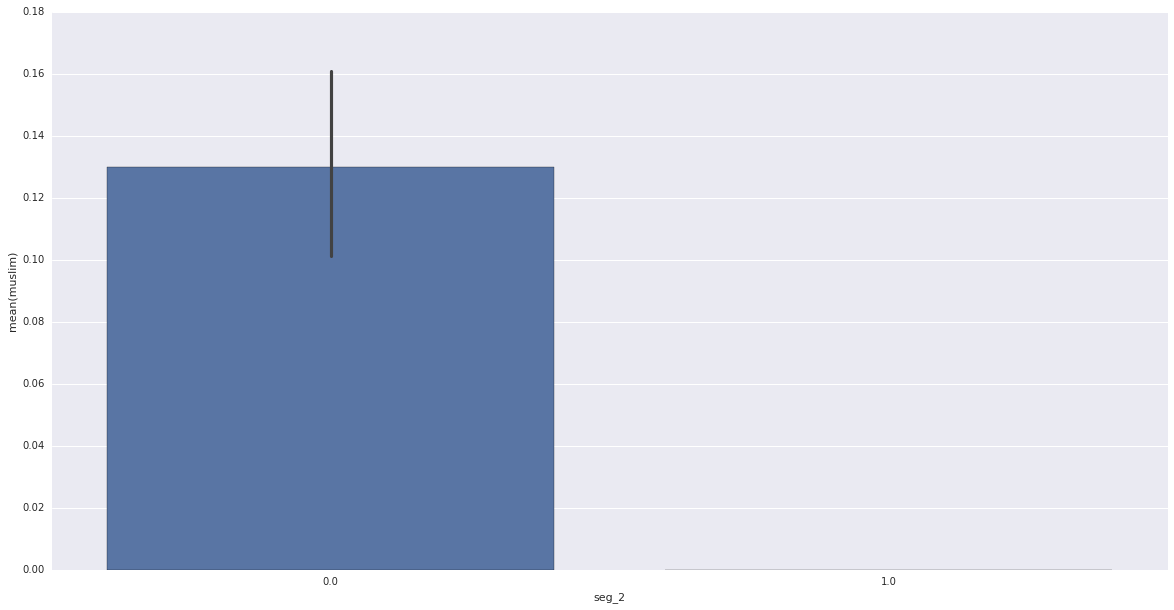

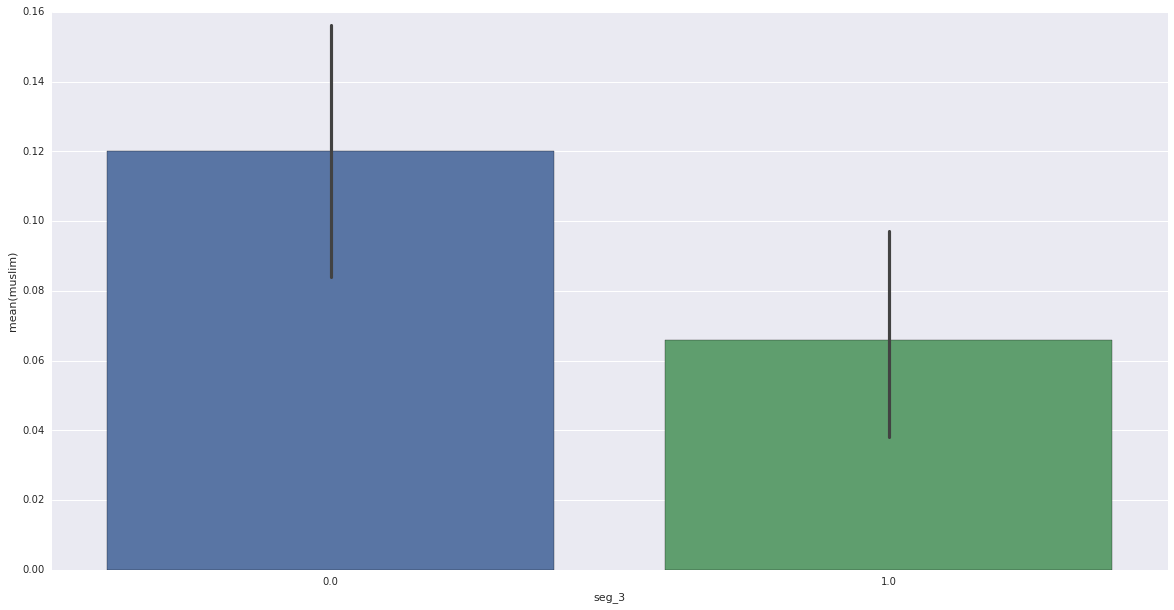

In [382]:
geo_5 = data[data['geo']==5].copy()
geo_5 = pd.concat([geo_5, pd.get_dummies(geo_5['segment'],prefix='seg')], axis=1, join='inner')
plt.figure(num = 1, figsize=(20, 10))
sns.barplot(data=geo_5, x='seg_1', y='muslim')
plt.figure(num = 2, figsize=(20, 10))
sns.barplot(data=geo_5, x='seg_2', y='muslim')
plt.figure(num = 3, figsize=(20, 10))
sns.barplot(data=geo_5, x='seg_3', y='muslim')

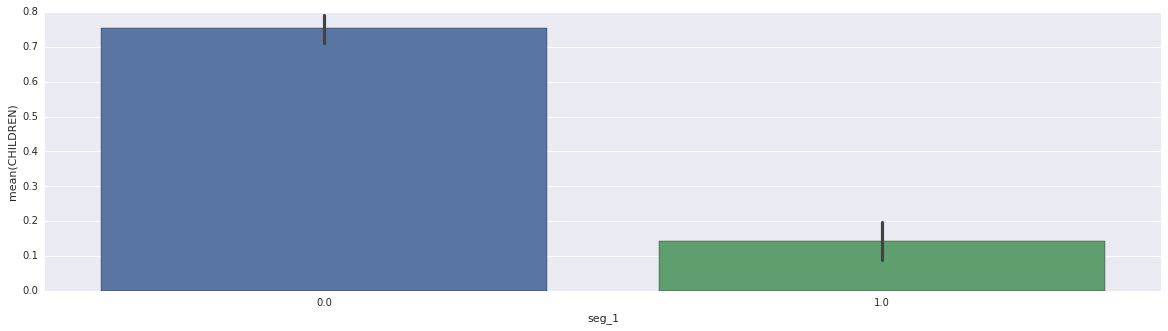

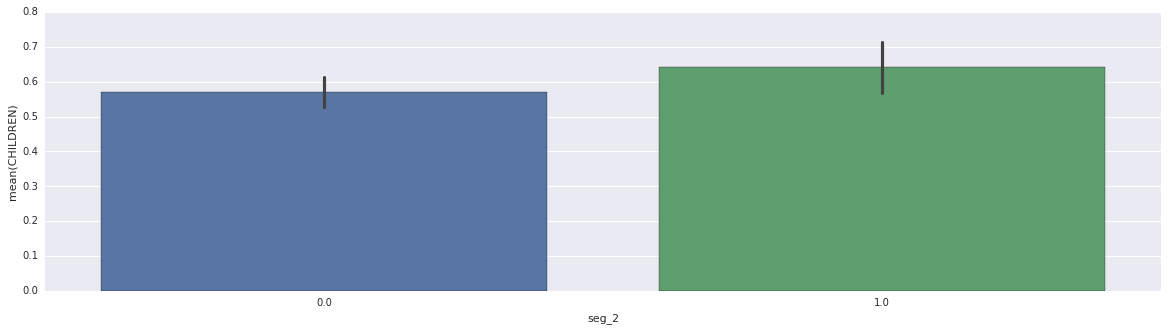

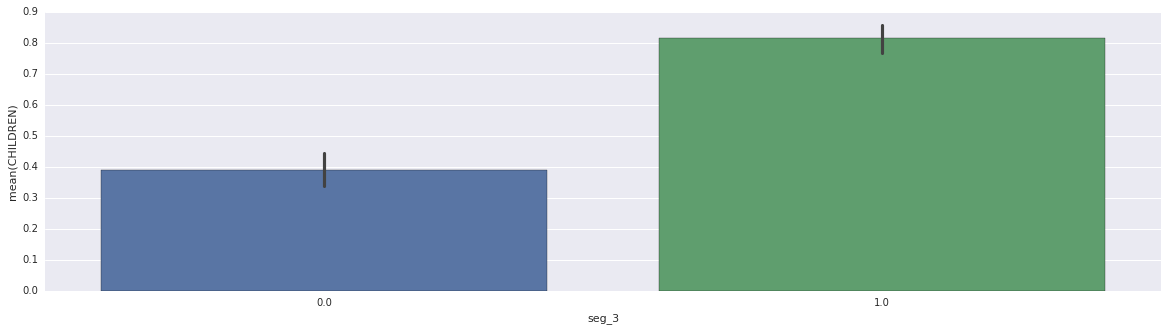

In [396]:
y = 'CHILDREN'
plt.figure(num = 1, figsize=(20, 5))
sns.barplot(data=geo_5, x='seg_1', y=y)
plt.figure(num = 2, figsize=(20, 5))
sns.barplot(data=geo_5, x='seg_2', y=y)
plt.figure(num = 3, figsize=(20, 5))
sns.barplot(data=geo_5, x='seg_3', y=y)

# Predict Segment
Using the predicted geo above, predict the segment within the geo. Through EDA, the discovery that each segment is unique within each geo.

Planning on building seperate Naive Bayes models for each geo.

In [453]:
global_predictors = ['multpart']
geo_segment_predictor_columns = {1:['EVER_HAD_SEX','EVER_BEEN_PREGNANT','CHILDREN','literacy'],
                 2:['christian','muslim','CHILDREN','ownincome','babydoc','ModCon','hivknow'],
                 3:['babydoc'],
                 4:[],
                 5:['muslim','babydoc','literacy','CHILDREN','EVER_BEEN_PREGNANT','educ'],
                 6:['EVER_HAD_SEX','single','EVER_BEEN_PREGNANT','CHILDREN','multpart','educ'],
                 7:['EVER_HAD_SEX','EVER_BEEN_PREGNANT','CHILDREN','educ','LaborDeliv','babydoc'],
                 8:['other','EVER_HAD_SEX','EVER_BEEN_PREGNANT','CHILDREN','married','multpart','inschool','LaborDeliv','babydoc','ModCon','hivknow'],
                 9:['christian','muslim','EVER_HAD_SEX','EVER_BEEN_PREGNANT','CHILDREN','married','multpart','inschool','babydoc']
                 }

In [454]:
import numpy as np

models = {}
fit_model = {}
for geo in data.geo.order().unique().tolist():
    if geo not in geo_segment_predictor_columns.keys():
        geo_segment_predictor_columns[geo] = []
    segment_predictor_columns = global_predictors + geo_segment_predictor_columns[geo]
    models[geo] = GaussianNB()
    segment_predictors = data[data['geo']==geo].dropna()[segment_predictor_columns]
    segment_train, segment_test, segment_y_train, segment_y_test = train_test_split(segment_predictors,
                                                                                    data[data['geo']==geo].dropna()['segment'],
                                                                                    test_size=0.33,
                                                                                    random_state=42)
    fit_model[geo] = models[geo].fit(segment_train ,y=segment_y_train)
    segment_predict = fit_model[geo].predict(segment_test)
    d = {'segment_y_test':segment_y_test,
         'segment_predict': segment_predict}
    
    geo_df = pd.DataFrame(data=d)
    
    print('========================')
    print('Geo: {}'.format(geo))
    print('Predicted Incorrectly: {}'.format(segment_y_test[segment_y_test != segment_predict].count()))
    print('Number to Predict: {}'.format(segment_y_test.count()))
    print('Percent Correct: %{}'.format((segment_y_test[segment_y_test == segment_predict].count()/segment_y_test.count())*100))
    print(geo_df[geo_df['segment_predict']==geo_df['segment_y_test']].head())
    print(geo_df[geo_df['segment_predict']!=geo_df['segment_y_test']].head())
    

Geo: 1
Predicted Incorrectly: 8
Number to Predict: 31
Percent Correct: %74.19354838709677
      segment_predict  segment_y_test
2217                2               2
1403                2               2
2884                2               2
4143                2               2
1610                2               2
      segment_predict  segment_y_test
210                 1               2
2075                1               2
840                 1               2
1073                1               2
4393                2               1
Geo: 2
Predicted Incorrectly: 64
Number to Predict: 81
Percent Correct: %20.98765432098765
      segment_predict  segment_y_test
4462                2               2
2617                4               4
3883                4               4
2988                4               4
617                 4               4
      segment_predict  segment_y_test
435                 4               1
211                 4               3
3363                4

In [457]:
print(data.ix[5152][geo_segment_predictor_columns[5]])
print(data.ix[1809][geo_segment_predictor_columns[5]])
print(data.ix[4527][geo_segment_predictor_columns[5]])

muslim                0
babydoc               0
literacy              3
CHILDREN              1
EVER_BEEN_PREGNANT    1
educ                  2
Name: 5152, dtype: object
muslim                0
babydoc               0
literacy              3
CHILDREN              1
EVER_BEEN_PREGNANT    1
educ                  1
Name: 1809, dtype: object
muslim                1
babydoc               4
literacy              0
CHILDREN              1
EVER_BEEN_PREGNANT    1
educ                  0
Name: 4527, dtype: object


#EDA SUBSET

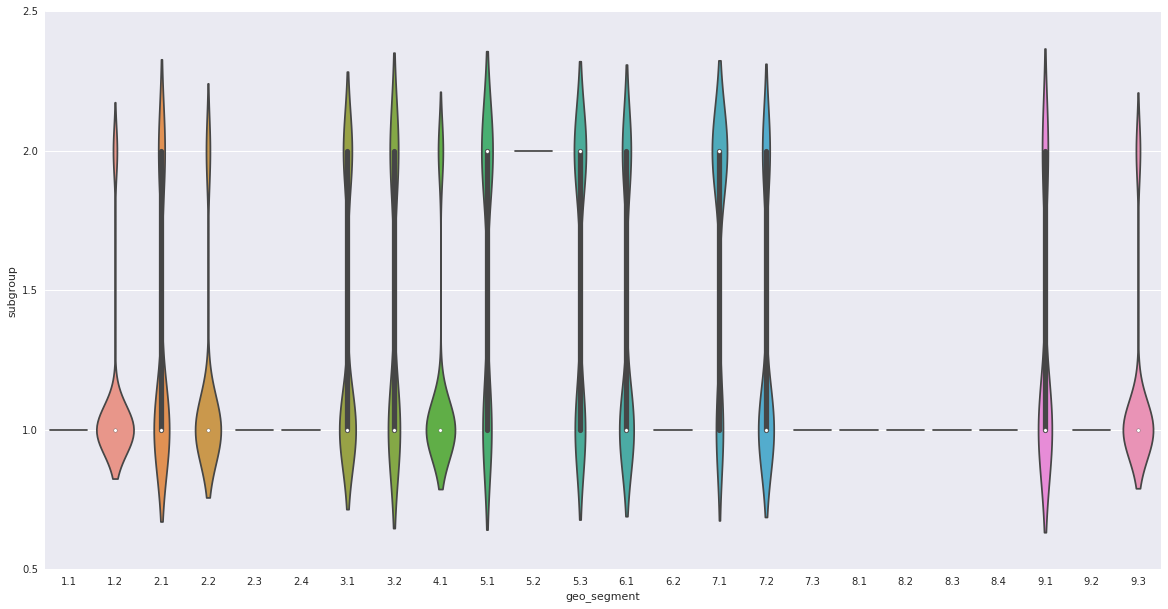

In [27]:
plt.figure(num = 1, figsize=(20, 10))
sns.violinplot(data=data[['geo_segment', 'subgroup', 'age','religion']],x='geo_segment', y='subgroup')

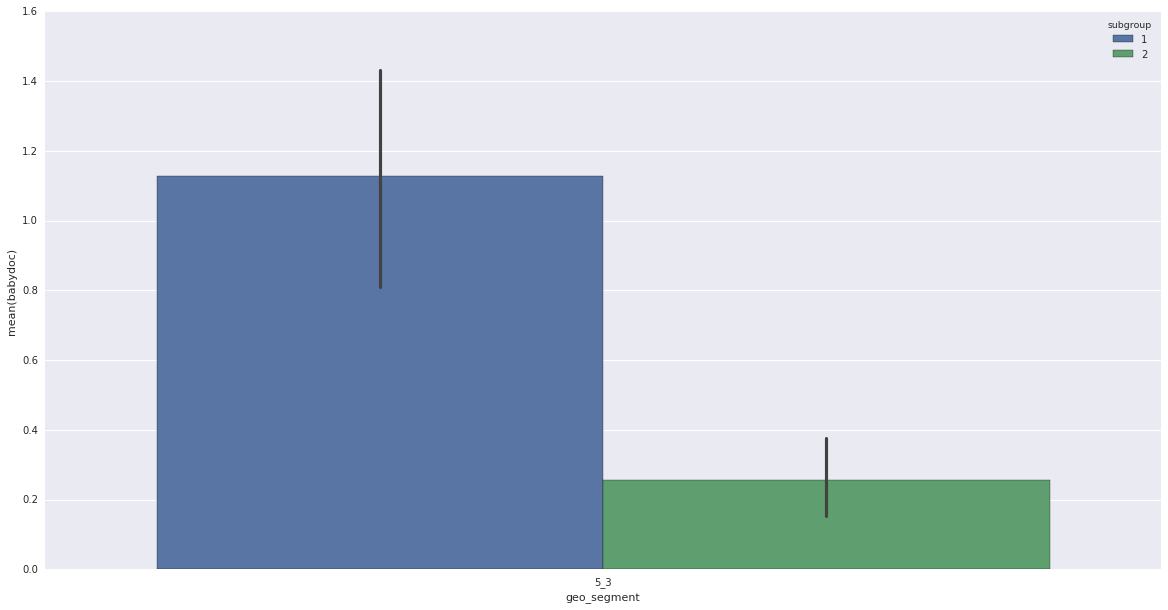

In [186]:
plt.figure(num = 1, figsize=(20, 10))
sns.barplot(data=data[data['geo_segment']=='5_3'],x='geo_segment',y='babydoc', hue='subgroup')

In [193]:
global_subgroup_predictors = ['geo','segment']
geo_segment_subgroup_predictor_columns = {'1.1':[],
                              '1_2':[],
                              '2_1':[],
                              '2_2':[],
                              '2_3':[],
                              '2_4':[],
                              '3_1':['ModCon'],
                              '3_2':['ModCon'],
                              '4_1':[],
                              '5_1':['babydoc'],
                              '5_2':[],
                              '5_3':['babydoc', 'usecondom','married','muslim'],
                              '6_1':['LaborDeliv',],
                              '6_2':[],
                              '7_1':['ModCon'],
                              '7_2':['EVER_HAD_SEX'],
                              '7_3':[],
                              '8_1':[],
                              '8_2':[],
                              '8_3':[],
                              '8_4':[],
                              '9_1':[],
                              '9_2':[],
                              '9_3':[]
                 }

In [205]:
models = {}
fit_model = {}
for geo_segment in data.geo_segment.order().unique().astype('str').tolist():
    if geo_segment not in geo_segment_subgroup_predictor_columns.keys():
        geo_segment_subgroup_predictor_columns[geo_segment] = []
    subgroup_predictor_columns = global_subgroup_predictors + geo_segment_subgroup_predictor_columns[geo_segment]
    models[geo_segment] = GaussianNB()
    subgroup_predictors = data[data['geo_segment']==geo_segment].fillna(value=0)[subgroup_predictor_columns]
    subgroup_train, subgroup_test, subgroup_y_train, subgroup_y_test = train_test_split(subgroup_predictors,
                                                                                    data[data['geo_segment']==geo_segment].fillna(value=0)['subgroup'],
                                                                                    test_size=0.33,
                                                                                    random_state=42)
    print('========================')
    print('GEO_SEGMENT: {}'.format(geo_segment))
    fit_model[geo_segment] = models[geo_segment].fit(subgroup_train ,y=subgroup_y_train)
    subgroup_predict = fit_model[geo_segment].predict(subgroup_test)
    
    print('Predicted Incorrectly: {}'.format(subgroup_y_test[subgroup_y_test != subgroup_predict].count()))
    print('Number to Predict: {}'.format(subgroup_y_test.count()))
    print('Percent Correct: %{}'.format((subgroup_y_test[subgroup_y_test == subgroup_predict].count()/subgroup_y_test.count())*100))

GEO_SEGMENT: 1_1
Predicted Incorrectly: 0
Number to Predict: 61
Percent Correct: %100.0
GEO_SEGMENT: 1_2
Predicted Incorrectly: 17
Number to Predict: 143
Percent Correct: %88.11188811188812
GEO_SEGMENT: 2_1
Predicted Incorrectly: 15
Number to Predict: 56
Percent Correct: %73.21428571428571
GEO_SEGMENT: 2_2
Predicted Incorrectly: 10
Number to Predict: 58
Percent Correct: %82.75862068965517
GEO_SEGMENT: 2_3
Predicted Incorrectly: 0
Number to Predict: 69
Percent Correct: %100.0
GEO_SEGMENT: 2_4
Predicted Incorrectly: 0
Number to Predict: 25
Percent Correct: %100.0
GEO_SEGMENT: 3_1
Predicted Incorrectly: 0
Number to Predict: 142
Percent Correct: %100.0
GEO_SEGMENT: 3_2
Predicted Incorrectly: 1
Number to Predict: 58
Percent Correct: %98.27586206896551
GEO_SEGMENT: 4_1
Predicted Incorrectly: 13
Number to Predict: 129
Percent Correct: %89.92248062015504
GEO_SEGMENT: 5_1
Predicted Incorrectly: 14
Number to Predict: 56
Percent Correct: %75.0
GEO_SEGMENT: 5_2
Predicted Incorrectly: 0
Number to P